In [1]:
import sys
import os
import SSGATE as ssgate
import scanpy as sc

import torch
import matplotlib.pyplot as plt

os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
# This tutorial is used to illustrate the steps of multi-omics integration of the BMNC dataset.
# Import transcriptome and proteome data in h5ad format
# adata_st = sc.read_h5ad('BMNC_RNA.h5ad')
# adata_sp = sc.read_h5ad('BMNC_ADT.h5ad')

adata_st = sc.read_h5ad("F:\liulin\BMNC\BMNC_RNA.h5ad")
adata_sp = sc.read_h5ad("F:\liulin\BMNC\BMNC_RNA.h5ad")

In [3]:
adata_st

AnnData object with n_obs × n_vars = 30672 × 17009
    obs: 'celltype_l1', 'celltype_l2'

In [4]:
adata_sp

AnnData object with n_obs × n_vars = 30672 × 17009
    obs: 'celltype_l1', 'celltype_l2'

Original ST Data Info: 30672 cells * 17009 genes.


E:\shichang\conda_envs\SSGATE\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
E:\shichang\conda_envs\SSGATE\lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
D:\ltx\SSGATE_using\SSGATE\preprocess_cluster.py:22: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_st, resolution = res_st, key_added = 'pre_label')


Original SP Data Info: 30672 cells * 17009 genes.
         Falling back to preprocessing with `sc.pp.pca` and default params.


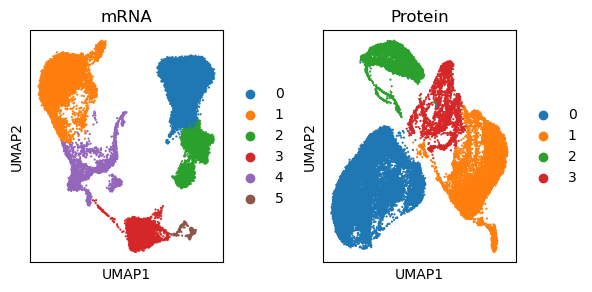

In [5]:
# The above data is not filtered or standardized by default, 
# and is preprocessed using the preprocessing function of SSGATE.
adata_st, adata_sp = ssgate.preprocess_cluster(adata_st, adata_sp, res_st = 0.1, res_sp = 0.05, show_fig = True, figsize = (6,3))

------Calculating spatial graph...
The graph contains 480170 edges, 30672 cells.
15.6550 neighbors per cell on average.
++++++Pruning the spatial graph!++++++
480170 edges before pruning.
475363 edges after pruning.


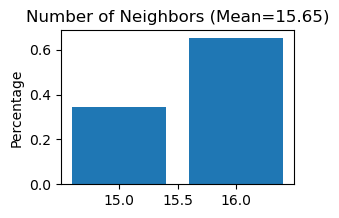

In [6]:
# Neighbor network construction, 
# network pruning, 
# and neighbor network statistics based on transcriptome data
adata_st = ssgate.Cal_Nbrs_Net(adata_st, feat = "X_pca", k_cutoff = 15, model = "KNN")
adata_st = ssgate.prune_net(adata_st)
ssgate.Stats_Nbrs_Net(adata_st)

------Calculating spatial graph...
The graph contains 479225 edges, 30672 cells.
15.6242 neighbors per cell on average.
++++++Pruning the spatial graph!++++++
479225 edges before pruning.
477771 edges after pruning.


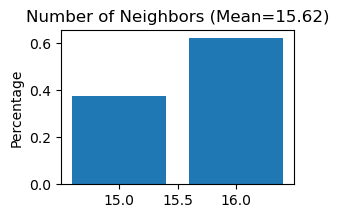

In [7]:
# Proteomic data are processed similarly to transcriptomic data
adata_sp = ssgate.Cal_Nbrs_Net(adata_sp, feat = "X_pca", k_cutoff = 15, model = "KNN")
adata_sp = ssgate.prune_net(adata_sp)
ssgate.Stats_Nbrs_Net(adata_sp)

In [8]:
# After the nearest neighbor network is built, it is trained based on the above data, 
# and the integrated results obtained from the training are retained in the .obsm file of h5ad.
adata_st, adata_sp = ssgate.train(adata_st, adata_sp, 
                                    hidden_dims1 = 128, 
                                    hidden_dims2 = 128, 
                                    out_dims = 30, 
                                    cluster_update_epoch = 50, 
                                    epochs_init = 50, 
                                    n_epochs=300, 
                                    save_reconstrction=False, 
                                    sigma = 0.1, 
                                    device = "cuda:0", 
                                    feat1 = "PCA",
                                    key_added = 'ssgate_embed')

  0%|          | 0/50 [00:00<?, ?it/s]E:\shichang\conda_envs\SSGATE\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
 42%|████▏     | 21/50 [00:33<00:46,  1.61s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.95 GiB (GPU 0; 24.00 GiB total capacity; 50.04 GiB already allocated; 0 bytes free; 52.08 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Calculate neighbors and construct UMAP graph based on integrated low-dimensional embedding
sc.pp.neighbors(adata_st, use_rep="ssgate_embed",key_added='SSGATE_neighbor')
sc.tl.umap(adata_st,neighbors_key='SSGATE_neighbor')

In [ ]:
# Leiden cluster statistics and drawing UMAP graph
sc.tl.leiden(adata_st, resolution = 0.15, key_added = "ssgate_cluster",neighbors_key='SSGATE_neighbor')
plt.rcParams["figure.figsize"] = [3,3]
sc.pl.umap(adata_st, color=["ssgate_cluster"], title = "SSGATE clusters")